# Occultation Quartic

In this notebook we validate our quartic expression for the points of intersection between the occultor and the day/night terminator.

In [2]:
%matplotlib inline

In [3]:
%run notebook_setup.py

In [48]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np

In [25]:
def plot(b, theta, xo, yo, ro):
    """Plot the occultor, the occulted body, and the day/night terminator."""
    # Equation of a rotated ellipse
    x0 = np.linspace(-1, 1, 1000)
    y0 = b * np.sqrt(1 - x0 ** 2)
    x = x0 * np.cos(theta) - y0 * np.sin(theta)
    y = x0 * np.sin(theta) + y0 * np.cos(theta)

    # Plot!
    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.add_artist(plt.Circle((0, 0), 1, ec="k", fc="none"))
    ax.add_artist(plt.Circle((xo, yo), ro, ec="k", fc="none"))
    ax.plot(x, y)
    ax.set_aspect(1)
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.01)
    ax.axis("off")
    return ax

Let's say we have the following occultor/occulted configuration in the occultor frame $\mathcal{F}'$ (in which the occultor lies along the $+y'$-axis:

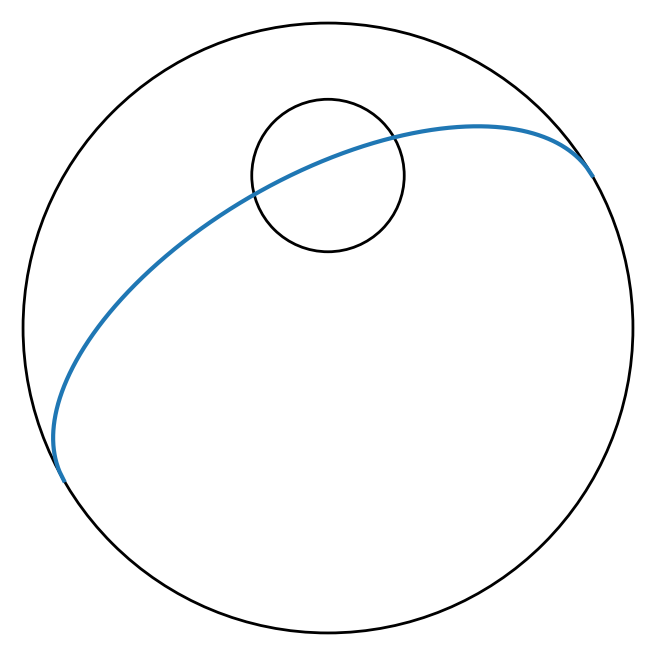

In [27]:
b = 0.5
theta = 30 * np.pi / 180
bo = 0.5
ro = 0.25
plot(b, theta, 0, bo, ro);

The occultor is the smaller circle and the day/night terminator is marked in blue. (The nightside can be either the region above or below this curve; it doesn't matter in this example).

We need to compute the points of intersection between the occultor and the terminator, as these will be our limits of integration for the flux integral. To do this, let's rotate into the frame $\mathcal{F}''$ in which the terminator is parallel to the $x''$-axis:

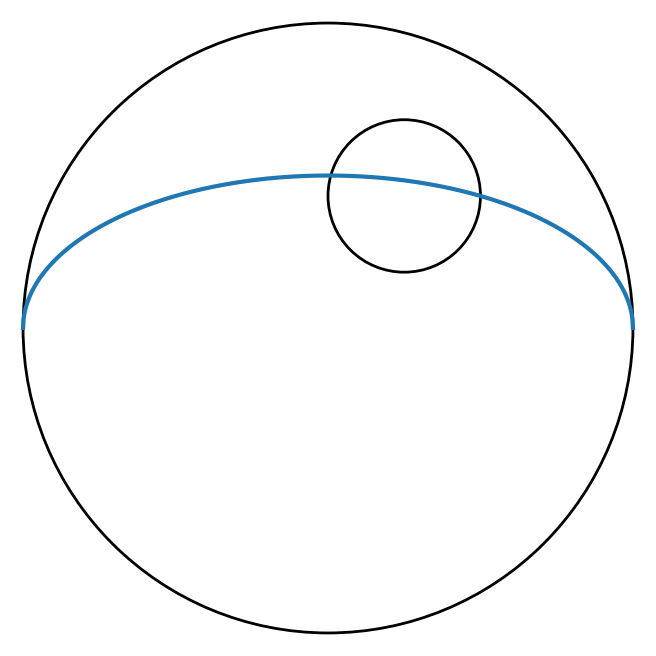

In [28]:
xo = bo * np.sin(theta)
yo = bo * np.cos(theta)
plot(b, 0, xo, yo, ro);

(Note that we dropped the primes from `xo` and `yo` for simplicity).

We claim in the paper that we can find the $x''$ coordinates of the intersection points by solving the following quartic:

$$
A {x''}^4 + B {x''}^3 + C {x''}^2 + D {x''} + E = 0
$$

where the coefficients are given by

In [29]:
def coeffs(b, xo, yo, ro):
    A = (1 - b ** 2) ** 2
    B = -4 * xo * (1 - b ** 2)
    C = -2 * (b ** 4 + ro ** 2 - 3 * xo ** 2 - yo ** 2 - b ** 2 * (1 + ro ** 2 - xo ** 2 + yo ** 2))
    D = -4 * xo * (b ** 2 - ro ** 2 + xo ** 2 + yo ** 2)
    E = b ** 4 - 2 * b ** 2 * (ro ** 2 - xo ** 2 + yo ** 2) + (ro ** 2 - xo ** 2 - yo ** 2) ** 2
    return np.array([A, B, C, D, E])

Let's find the roots with `np.roots`:

In [40]:
x = np.roots(coeffs(b, xo, yo, ro))
print(x)

[0.4120987 +1.16207686j 0.4120987 -1.16207686j 0.5       +0.j
 0.00913594+0.j        ]


Let's get rid of the imaginary ones...

In [44]:
x = np.array([xi.real for xi in x if xi.imag == 0])

And compute the corresponding `y` values:

In [45]:
y = b * np.sqrt(1 - x ** 2)

Finally, let's rotate back to the occultor frame $\mathcal{F}'$ and see if we got the points right:

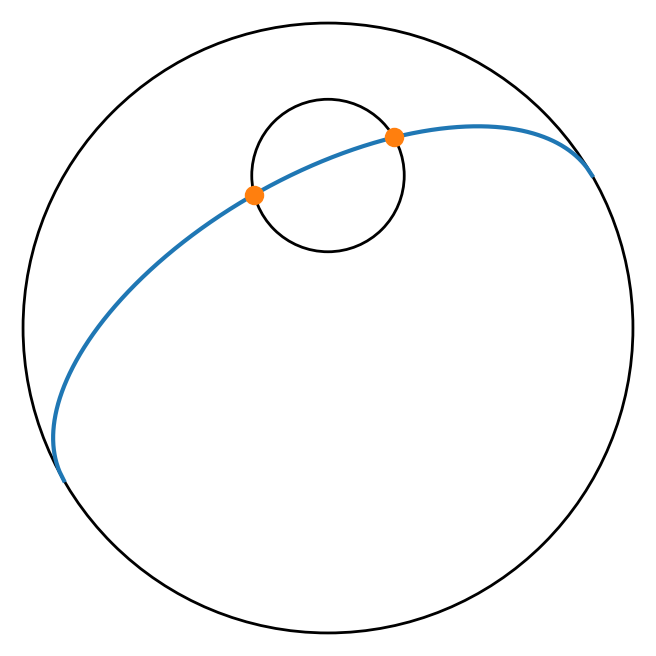

In [47]:
xprime = x * np.cos(theta) - y * np.sin(theta)
yprime = x * np.sin(theta) + y * np.cos(theta)
ax = plot(b, theta, 0, bo, ro)
ax.plot(xprime, yprime, "C1o");

Looks great! We can explore different configurations with the following widget:

In [64]:
@widgets.interact(b=(-1.0, 1.0), theta=(0.0, 2 * np.pi), bo=(0.0, 1.0), ro=(0.0, 0.75))
def visualize(b=0.5, theta=np.pi/6, bo=0.5, ro=0.25):
    xo = bo * np.sin(theta)
    yo = bo * np.cos(theta)
    x = np.roots(coeffs(b, xo, yo, ro))
    
    # Note we allow imagininary solutions with some tolerance
    x = np.array([xi.real for xi in x if np.abs(xi.imag) < 1e-8])
    y = b * np.sqrt(1 - x ** 2)    
    xprime = x * np.cos(theta) - y * np.sin(theta)
    yprime = x * np.sin(theta) + y * np.cos(theta)
    
    # We need to be careful to exclude roots corresponding to
    # the *backside* of the terminator.
    good = np.abs(xprime ** 2 + (yprime - bo) ** 2 - ro ** 2) < 1e-8
    xprime = xprime[good]
    yprime = yprime[good]
    
    ax = plot(b, theta, 0, bo, ro)
    ax.plot(xprime, yprime, "C1o");

interactive(children=(FloatSlider(value=0.5, description='b', max=1.0, min=-1.0), FloatSlider(value=0.52359877…

Keep in mind that in `starry` we further polish the roots using Newton's method and implement several checks to ensure we have found all the correct roots. The implementation above is only meant to illustrate how the method works.